In [1]:
import numpy as np
import pandas as pd
import astroquery
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from numpy.random import poisson, beta, uniform

import occSimFuncs as occFunc
from tvguide import TessPointing

from astropy.coordinates import SkyCoord
from astropy import units as u

%matplotlib inline

In [2]:
msun = 1.9891E30
rsun = 695500000.
G = 6.67384E-11
AU = 149597870700.

consts = {'sigma_threshold': 7.3}

In [3]:
# load the targets
# files are 
# selectedreal5-LongerBaseline-v2.csv.bz2
# selectedreal5-Nominal-v2.csv.bz2
# selectedreal5-MoreStars-v2.csv.bz2

fn = '../data/selectedreal5-Nominal-v2.csv.bz2'

df = pd.read_csv(fn)

In [4]:
# some things we are going to need later
df['isMdwarf'] = np.where((df.TEFF < 3900) & (df.RADIUS < 0.5), True, False)
df['isGiant'] = np.ones(df.shape[0], dtype='bool') # assume all dwarfs

df['cosi'] = pd.Series(np.random.random(size=df.shape[0]),name='cosi')

df['noise_level'] = occFunc.component_noise(df.TESSMAG, readmod=1, zodimod=1)

df['nsectors'] = np.round(df.obs_len/27.4)

In [5]:
print('total stars = {}'.format(df[df.tess_ccd > 0].shape[0]))
print('total target slots = {}'.format(np.sum(df.obs_len) / 27.4))

total stars = 203771
total target slots = 412240.0000012322


In [6]:
# how many planets should each star get
np_fgk = poisson(lam=0.689,size=df.shape[0])
np_m = poisson(lam=2.5,size=df.shape[0])
df['Nplanets'] = pd.Series(np.where(df.isMdwarf, np_m, np_fgk), name='Nplanets')

In [7]:
# draw a bunch of planest and accociate them with each star
starID = 0 # ???
newDF, starID = occFunc.make_allplanets_df_vec(df, starID)

# get some transit epochs
newDF = newDF.assign(T0=pd.Series(uniform(0, 1, size=newDF.shape[0]) * newDF.loc[:, 'planetPeriod']))

#calculate the number of transits
nt1 = np.floor(newDF['obs_len'] / newDF.planetPeriod)
newDF['Ntransits'] = np.where(newDF['T0'] < newDF['obs_len'] % newDF.planetPeriod, nt1+1,nt1)
newDF['ars'] = occFunc.per2ars(newDF.planetPeriod, newDF.MASS, newDF.RADIUS)
newDF['ecc'] = pd.Series(beta(1.03,13.6,size=newDF.shape[0]),name='ecc', ) # ecc dist from Van Eylen 2015
newDF['omega'] = pd.Series(uniform(-np.pi,np.pi,size=newDF.shape[0]),name='omega')
newDF['rprs'] = occFunc.get_rprs(newDF.planetRadius, newDF.RADIUS)
newDF['impact'] = newDF.cosi * newDF.ars * ((1-newDF.ecc**2)/1+newDF.ecc*np.sin(newDF.omega)) # cite Winn
newDF['duration'] = occFunc.get_duration(newDF.planetPeriod, newDF.ars, cosi=newDF.cosi, b=newDF.impact,
                                rprs=newDF.rprs) # cite Winn
newDF['duration_correction'] = np.sqrt(newDF.duration * 24.) # correction for CDPP because transit dur != 1 hour
newDF['transit_depth']  = occFunc.get_transit_depth(newDF.planetRadius, newDF.RADIUS)

newDF['transit_depth_diluted']  = newDF['transit_depth'] / (1+newDF.CONTRATIO)

/Users/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/tom/gitcode/tyieldsim/code/occSimFuncs.py:28: RuntimeWarning: invalid value encountered in sqrt
  part3 = np.sqrt((1 + rprs)**2 - b**2)
/Users/tom/gitcode/tyieldsim/code/occSimFuncs.py:30: RuntimeWarning: invalid value encountered in arcsin
  duration = part1 * np.arcsin(part2 * part3 / part4)


In [8]:
# now lets see if those planets are detected
newDF['needed_for_detection'] = (newDF.transit_depth_diluted * newDF.duration_correction *
                    np.sqrt(newDF.Ntransits)) / consts['sigma_threshold']

newDF['has_transits']  = (newDF.ars > 1.0) & (newDF.impact < 1.0)

In [9]:
newDF['detected'] = (newDF.noise_level < newDF.needed_for_detection) & (newDF.Ntransits >= 3) & (newDF.planetRadius > 0.0) & newDF.has_transits


total_planets = newDF.detected.sum()

In [10]:
total_planets

875

In [11]:
detected_DF = newDF[newDF.detected == True]

In [20]:
df = pd.read_csv(fn)
df_orig = df.copy()
tp = np.array([])
for x in tqdm(range(100)):
    df = df_orig.copy()
    # some things we are going to need later
    df['isMdwarf'] = np.where((df.TEFF < 3900) & (df.RADIUS < 0.5), True, False)
    df['isGiant'] = np.ones(df.shape[0], dtype='bool') # assume all dwarfs

    df['cosi'] = pd.Series(np.random.random(size=df.shape[0]),name='cosi')

    df['noise_level'] = occFunc.component_noise(df.TESSMAG, readmod=1, zodimod=1)
    # how many planets should each star get
    np_fgk = poisson(lam=0.689,size=df.shape[0])
    np_m = poisson(lam=2.5,size=df.shape[0])
    df['Nplanets'] = pd.Series(np.where(df.isMdwarf, np_m, np_fgk), name='Nplanets')
    # draw a bunch of planest and accociate them with each star
    starID = 0 # ???
    newDF, starID = occFunc.make_allplanets_df_vec(df, starID)

    # get some transit epochs
    newDF = newDF.assign(T0=pd.Series(uniform(0, 1, size=newDF.shape[0]) * newDF.loc[:, 'planetPeriod']))

    #calculate the number of transits
    nt1 = np.floor(newDF['obs_len'] / newDF.planetPeriod)
    newDF['Ntransits'] = np.where(newDF['T0'] < newDF['obs_len'] % newDF.planetPeriod, nt1+1,nt1)
    newDF['ars'] = occFunc.per2ars(newDF.planetPeriod, newDF.MASS, newDF.RADIUS)
    newDF['ecc'] = pd.Series(beta(1.03,13.6,size=newDF.shape[0]),name='ecc', ) # ecc dist from Van Eylen 2015
    newDF['omega'] = pd.Series(uniform(-np.pi,np.pi,size=newDF.shape[0]),name='omega')
    newDF['rprs'] = occFunc.get_rprs(newDF.planetRadius, newDF.RADIUS)
    newDF['impact'] = newDF.cosi * newDF.ars * ((1-newDF.ecc**2)/1+newDF.ecc*np.sin(newDF.omega)) # cite Winn
    newDF['duration'] = occFunc.get_duration(newDF.planetPeriod, newDF.ars, cosi=newDF.cosi, b=newDF.impact,
                                    rprs=newDF.rprs) # cite Winn
    newDF['duration_correction'] = np.sqrt(newDF.duration * 24.) # correction for CDPP because transit dur != 1 hour
    newDF['transit_depth']  = occFunc.get_transit_depth(newDF.planetRadius, newDF.RADIUS)

    newDF['transit_depth_diluted']  = newDF['transit_depth'] / (1+newDF.CONTRATIO)
    # now lets see if those planets are detected
    newDF['needed_for_detection'] = (newDF.transit_depth_diluted * newDF.duration_correction *
                        np.sqrt(newDF.Ntransits)) / consts['sigma_threshold']

    newDF['has_transits']  = (newDF.ars > 1.0) & (newDF.impact < 1.0)
    newDF['detected'] = (newDF.noise_level < newDF.needed_for_detection) & (newDF.Ntransits >= 3) & (newDF.planetRadius > 0.0) & newDF.has_transits


    total_planets = newDF.detected.sum()
    tp = np.r_[tp,total_planets]
    if total_planets == 920:
        break

  0%|          | 0/100 [00:00<?, ?it/s]/Users/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/tom/gitcode/tyieldsim/code/occSimFuncs.py:28: RuntimeWarning: invalid value encountered in sqrt
  part3 = np.sqrt((1 + rprs)**2 - b**2)
/Users/tom/gitcode/tyieldsim/code/occSimFuncs.py:30: RuntimeWarning: invalid value encountered in arcsin
  duration = part1 * np.arcsin(part2 * part3 / part4)
  7%|▋         | 7/100 [00:31<07:08,  4.61s/it]

In [21]:
detected_DF = newDF[newDF.detected == True]

In [22]:
detected_DF.shape

(920, 37)

In [27]:
newDF.to_csv('../data/fiducial.csv.bz2', compression='bz2')

In [23]:
['{}: {} & {} & {}'.format(x,*np.percentile(detected_DF.loc[:,x], [50,5,95], axis=0)) for x in detected_DF.columns]

['Unnamed: 0: 4506032.0 & 481249.0 & 10109499.35',
 'RA: 198.46166449999998 & 24.27782105 & 339.71100595',
 'DEC: 5.6802814999999995 & -74.42965699999999 & 74.66597665',
 'ECLONG: 174.0080405 & 17.11732995 & 339.93383509999995',
 'ECLAT: 10.8505865 & -81.09881594999999 & 81.54982774999998',
 'Ks: 9.421 & 6.752599805000001 & 11.551549999999997',
 'TESSMAG: 11.036000000000001 & 7.734450094999999 & 14.126249999999999',
 'TEFF: 4124.5 & 3120.8 & 6496.2',
 'RADIUS: 0.6574665049999999 & 0.2208499995 & 1.476916505',
 'MASS: 0.665853175 & 0.19579999050000002 & 1.343438535',
 'CONTRATIO: 0.011017332500000001 & 4.7589651100000014e-05 & 0.36673609849999994',
 'PRIORITY: 0.0705013835 & 0.04801946185 & 0.20760813949999998',
 'SELECTED: 1.0 & 1.0 & 1.0',
 'tess_ccd: 2.0 & 1.0 & 4.0',
 'obs_len: 54.8 & 27.4 & 356.2',
 'isMdwarf: 0.0 & 0.0 & 1.0',
 'isGiant: 1.0 & 1.0 & 1.0',
 'cosi: 0.02180012227831718 & 0.001663219112659753 & 0.08760939212474324',
 'noise_level: 348.0947299277502 & 85.45560968568488

In [24]:
# duration = 0.08409320732236308*24, 0.03254344397594473*24, 0.21720016184307991*24
np.percentile(detected_DF.loc[:,'duration'], [50,5,95], axis=0) * 24

array([ 2.04465705,  0.80285322,  5.0740137 ])

In [25]:
np.percentile(detected_DF.needed_for_detection * 7.3 / detected_DF.noise_level, [50,5,95])

array([  13.90209475,    7.6680066 ,  102.93023   ])

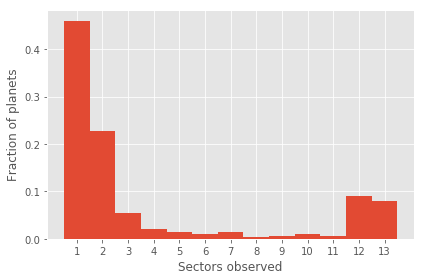

In [26]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1)
    ax.hist(detected_DF.obs_len / 27.4, bins=np.arange(0.5,14.5,1), cumulative=False, normed=True)
    ax.set_xlabel('Sectors observed')
    ax.set_ylabel('Fraction of planets')
    ax.xaxis.set_ticks(range(1,14,1))
#     ax.xaxis.set_ticklabels(range(1,14,1))
    fig.tight_layout()
    fig.savefig('../plots/obs_len.png', dpi=200)

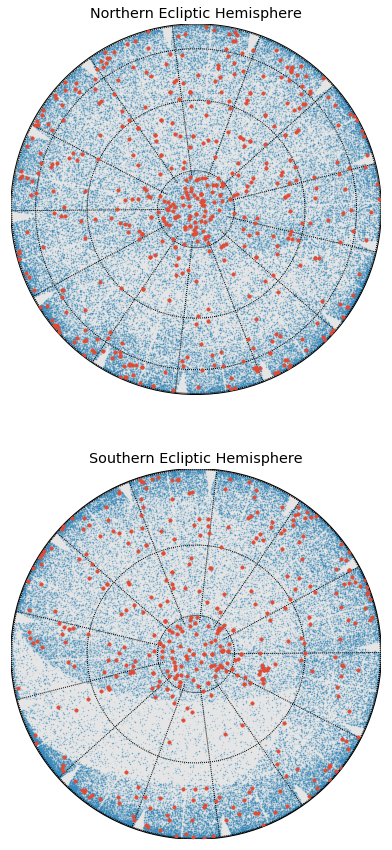

In [140]:

from mpl_toolkits.basemap import Basemap
with plt.style.context('ggplot'):
    fig, [ax1, ax2] = plt.subplots(2,1, figsize=[15,15])
    m = Basemap(projection='ortho',lon_0=0,lat_0=90,resolution='l', celestial=True, ax=ax1)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=12, alpha=1, latlon=True, zorder=100)
    m.scatter(newDF[newDF.tess_ccd > 0].ECLONG.values, newDF[newDF.tess_ccd > 0].ECLAT.values, 
              s=1, alpha=0.1, latlon=True)
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

    m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax2)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=12, alpha=1, latlon=True, zorder=100)
    m.scatter(newDF[newDF.tess_ccd > 0].ECLONG.values, newDF[newDF.tess_ccd > 0].ECLAT.values, 
              s=1, alpha=0.1, latlon=True)
    parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, latmin=-78)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)
    ax1.set_title('Northern Ecliptic Hemisphere')
    ax2.set_title('Southern Ecliptic Hemisphere')

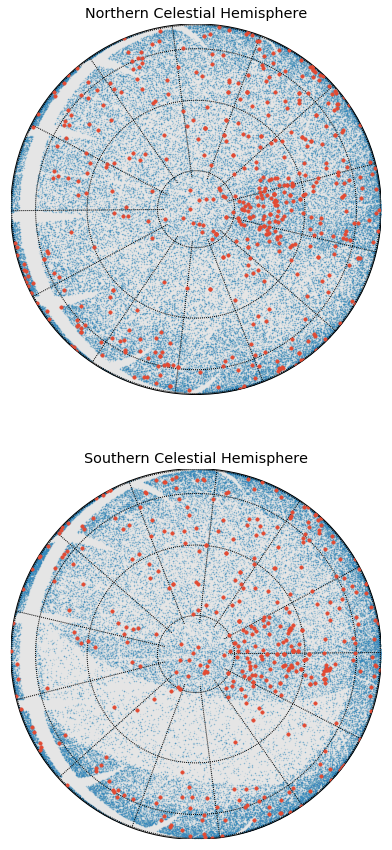

In [145]:
from mpl_toolkits.basemap import Basemap
with plt.style.context('ggplot'):
    fig, [ax1, ax2] = plt.subplots(2,1, figsize=[15,15])
    m = Basemap(projection='ortho',lon_0=0,lat_0=90,resolution='l', celestial=True, ax=ax1)
    m.scatter(detected_DF.RA.values, detected_DF.DEC.values, s=12, alpha=1, latlon=True, zorder=100)
    m.scatter(newDF[newDF.tess_ccd > 0].RA.values, newDF[newDF.tess_ccd > 0].DEC.values, 
              s=1, alpha=0.1, latlon=True)
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

    m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax2)
    m.scatter(detected_DF.RA.values, detected_DF.DEC.values, s=12, alpha=1, latlon=True, zorder=100)
    m.scatter(newDF[newDF.tess_ccd > 0].RA.values, newDF[newDF.tess_ccd > 0].DEC.values, 
              s=1, alpha=0.1, latlon=True)
    parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, latmin=-78)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)
    ax1.set_title('Northern Celestial Hemisphere')
    ax2.set_title('Southern Celestial Hemisphere')

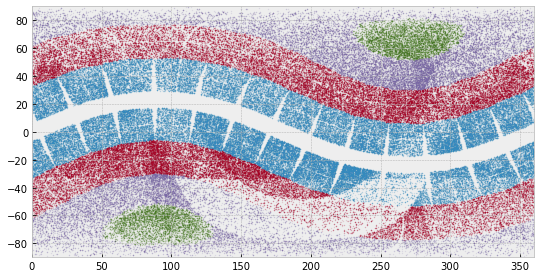

In [170]:
with plt.style.context('bmh'):
    fig, ax = plt.subplots(1,1, figsize=[9,9])
    ax.scatter(newDF[newDF.tess_ccd == 1].RA, newDF[newDF.tess_ccd ==1].DEC, s=1, alpha=0.1)
    ax.scatter(newDF[newDF.tess_ccd == 2].RA, newDF[newDF.tess_ccd ==2].DEC, s=1, alpha=0.1)
    ax.scatter(newDF[newDF.tess_ccd == 3].RA, newDF[newDF.tess_ccd ==3].DEC, s=1, alpha=0.1)
    ax.scatter(newDF[newDF.tess_ccd == 4].RA, newDF[newDF.tess_ccd ==4].DEC, s=1, alpha=0.1)
    ax.set_xlim(0,360)
    ax.set_ylim(-90,90)
    ax.set_aspect('equal')

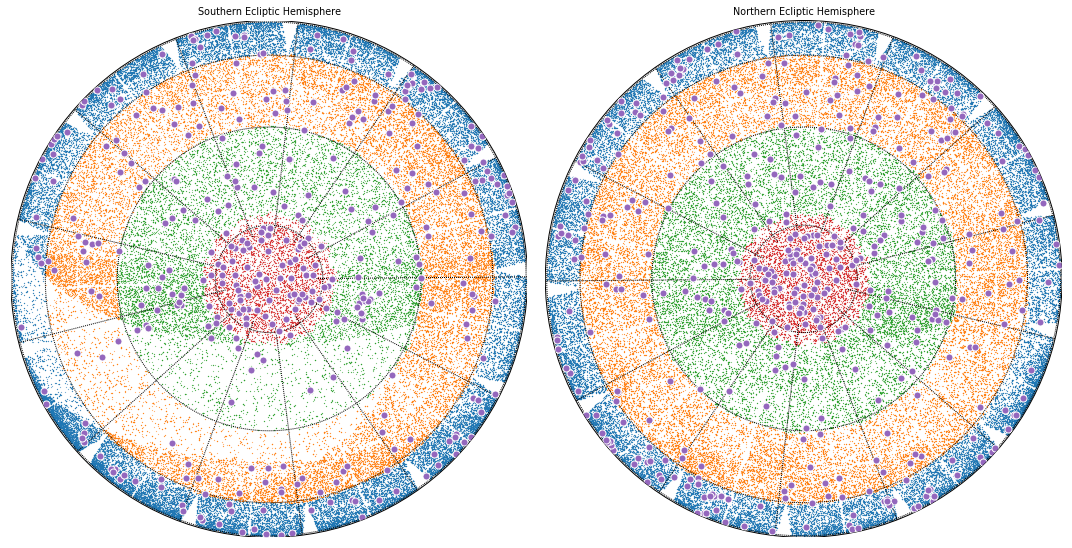

In [193]:

from mpl_toolkits.basemap import Basemap
with plt.style.context('seaborn-paper'):
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=[15,8])
    m = Basemap(projection='ortho',lon_0=0,lat_0=90,resolution='l', celestial=True, ax=ax2)
    m.scatter(newDF[newDF.tess_ccd ==1].ECLONG.values, newDF[newDF.tess_ccd ==1].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==2].ECLONG.values, newDF[newDF.tess_ccd ==2].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==3].ECLONG.values, newDF[newDF.tess_ccd ==3].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==4].ECLONG.values, newDF[newDF.tess_ccd ==4].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=50, lw=1, edgecolor='w',
              alpha=1, latlon=True, zorder=100)
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

    m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax1)
    m.scatter(newDF[newDF.tess_ccd ==1].ECLONG.values, newDF[newDF.tess_ccd ==1].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==2].ECLONG.values, newDF[newDF.tess_ccd ==2].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==3].ECLONG.values, newDF[newDF.tess_ccd ==3].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF[newDF.tess_ccd ==4].ECLONG.values, newDF[newDF.tess_ccd ==4].ECLAT.values, 
              s=1, alpha=0.5, latlon=True)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=1, edgecolor='w',
              s=50, alpha=1, latlon=True, zorder=100)
    parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, latmin=-78)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)
    ax2.set_title('Northern Ecliptic Hemisphere')
    ax1.set_title('Southern Ecliptic Hemisphere')
    fig.tight_layout()
    fig.savefig('../plots/skyplot.png', dpi=200)

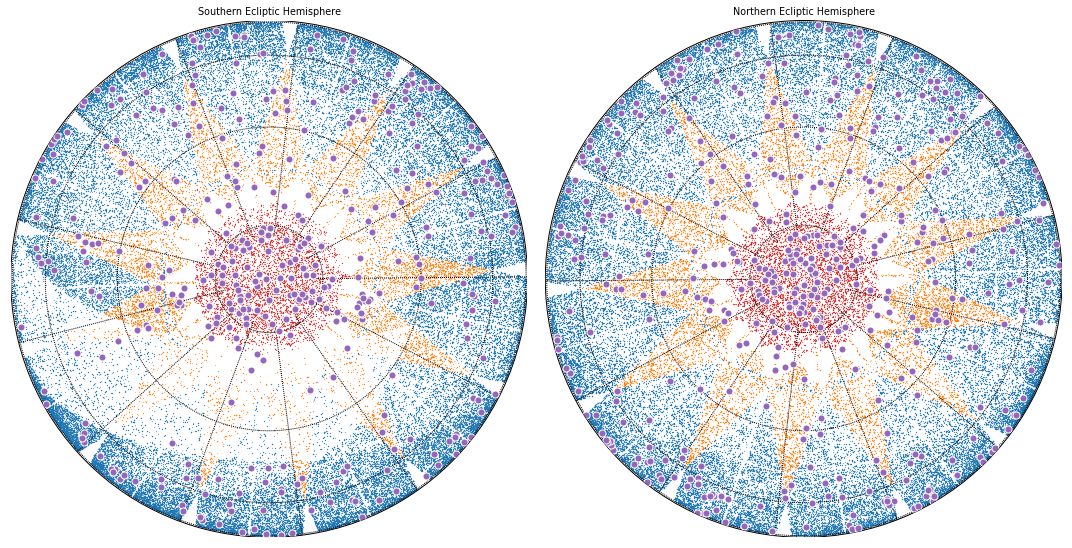

In [210]:

from mpl_toolkits.basemap import Basemap
with plt.style.context('seaborn-paper'):
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=[15,8])
    m = Basemap(projection='ortho',lon_0=0,lat_0=90,resolution='l', celestial=True, ax=ax2)
    m.scatter(newDF.ECLONG.values[newDF. == 27.4], newDF.ECLAT.values[newDF.obs_len == 27.4], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len == 27.4*2], newDF.ECLAT.values[newDF.obs_len == 27.4*2], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len == 27.4*3], newDF.ECLAT.values[newDF.obs_len == 27.4*3], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len > 27.4*3], newDF.ECLAT.values[newDF.obs_len > 27.4*3], 
              s=1, alpha=0.5, latlon=True)

    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=50, lw=1, edgecolor='w',
              alpha=1, latlon=True, zorder=100)
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

    m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax1)
    m.scatter(newDF.ECLONG.values[newDF.obs_len == 27.4], newDF.ECLAT.values[newDF.obs_len == 27.4], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len == 27.4*2], newDF.ECLAT.values[newDF.obs_len == 27.4*2], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len == 27.4*3], newDF.ECLAT.values[newDF.obs_len == 27.4*3], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.obs_len > 27.4*3], newDF.ECLAT.values[newDF.obs_len > 27.4*3], 
              s=1, alpha=0.5, latlon=True)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=1, edgecolor='w',
              s=50, alpha=1, latlon=True, zorder=100)
    parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, latmin=-78)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)
    ax2.set_title('Northern Ecliptic Hemisphere')
    ax1.set_title('Southern Ecliptic Hemisphere')
    fig.tight_layout()
#     fig.savefig('../plots/skyplot.png', dpi=200)

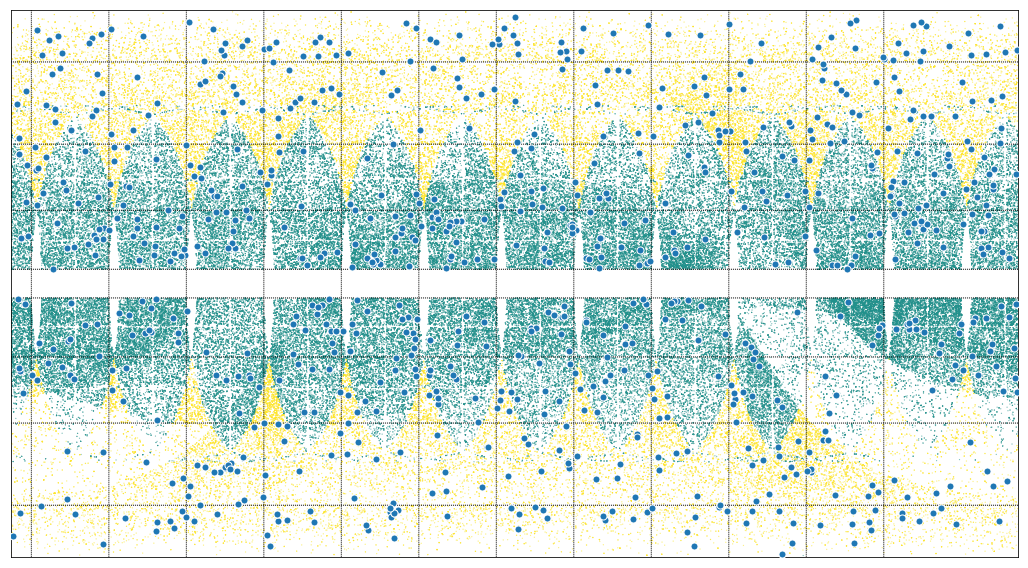

In [200]:

from mpl_toolkits.basemap import Basemap
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1,1, figsize=[15,8])
    m = Basemap(projection='gall', resolution='l', celestial=True, ax=ax)
#     m.scatter(newDF[newDF.tess_ccd ==1].ECLONG.values, newDF[newDF.tess_ccd ==1].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==2].ECLONG.values, newDF[newDF.tess_ccd ==2].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==3].ECLONG.values, newDF[newDF.tess_ccd ==3].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==4].ECLONG.values, newDF[newDF.tess_ccd ==4].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=50, lw=1, edgecolor='w',
              alpha=1, latlon=True, zorder=100)
    m.scatter(newDF.ECLONG.values, newDF.ECLAT.values, 
              s=1, alpha=0.5, latlon=True, c=newDF.obs_len.values, vmin=0, vmax=27.4*2)
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

#     m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax1)
#     m.scatter(newDF[newDF.tess_ccd ==1].ECLONG.values, newDF[newDF.tess_ccd ==1].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==2].ECLONG.values, newDF[newDF.tess_ccd ==2].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==3].ECLONG.values, newDF[newDF.tess_ccd ==3].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(newDF[newDF.tess_ccd ==4].ECLONG.values, newDF[newDF.tess_ccd ==4].ECLAT.values, 
#               s=1, alpha=0.5, latlon=True)
#     m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=1, edgecolor='w',
#               s=50, alpha=1, latlon=True, zorder=100)
#     parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
#     m.drawparallels(parallels, latmax=78, latmin=-78)
#     meridians = np.linspace(240-12,360+240-12,14)[:-1]
#     m.drawmeridians(meridians,)
#     ax2.set_title('Northern Ecliptic Hemisphere')
#     ax1.set_title('Southern Ecliptic Hemisphere')
    fig.tight_layout()
#     fig.savefig('../plots/skyplot.png', dpi=200)

(50, 78)

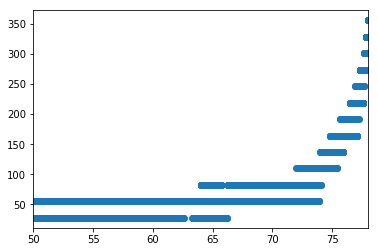

In [212]:
plt.scatter(newDF.ECLAT, newDF.obs_len)
plt.xlim(50,78)